#What Makes For a Popular Post in Sports Subreddits?
<b>Website link for our notebook: <a href="https://xiaojingni.github.io/group22-eda/" target="_blank">https://xiaojingni.github.io/group22-eda/</a></b>

The topic we would like to generally explore for our project is what factors influence the popularity or reception of a given reddit post. <br>
Because the genre or type of subreddit may have some influence over these factors, we will pick subreddits related to sports as a common denominator <br>
from which to explore this question. (e.g. `nba`, `nfl`, `mlb`, etc.) We will also analyze questions related to specific sports' subreddits <br>
and potentially address implications these findings may have about the sports themselves to suplement our analysis and provide further interesting discussion.<br>

We will attempt to address these 10 business questions and provide a technical approach for tackling each question:</b><br> <br>
<ol>
<b><li>Are certain types of media more present within popular posts? </b><br>
   Technical Proposal: For a given sports subreddit, utilize regex with the has_media field, the url field, and other fields to identify if posts <br>
   have different types of associated media (i.e. photos, videos, etc.). Then, see if these posts on average are more or less popular. <br>
    Utilize 'score' as the primary metric to measure popularity.<br></li>
    
<b><li>Do popular posts have a higher amount of crossposts into other subreddits? </b><br>
   Technical Proposal: For a given sports subreddit, find if posts with many cross posts are more or less popular on average utilizing score as the metric for popularity. <br>
   Determine if there is a correlation between a post's score and the number of crossposts that the post receieved.</li>

<b><li>Does having previously successful posts impact the likelihood of having another successful post?</b><br>
   Technical Proposal: Create a new field measuring aggregate user score over time.<br>
    Evaluate whether the aggregate score by user is correlated with the score of a given post.</li>
  
<b><li>Does ad status influence the popularity of a given post? </b><br>
  Technical Proposal: Determine if the ad status (indicated by `whitelist_status`) is correlated with visibility. <br>
  Utilize the score metric as a proxy for visibility.<br></li>
  
<b><li>Do gilded posts receive higher scores on average than non-gilded posts? </b><br>
   Technical Proposal: Correlate the gilded count field with the score field. Evaluate if this correlation is signficant.</li>
  
<b><li>What are the distributions of the submission post time of different subreddits? Are there any differences among them? Does score vary with time of posting?</li> </b><br>
  Technical Proposal: Create two new fields based on the `create_utc` field of the submission data for at least two subreddits. One of the fields can be the <br>
   time of the day, while the other is the day of the week. With these two fields, obtain counts to find the distribution of the submission number of each time slot and each day of the week.<br>
  
<b><li>Compare the distribution of positive and negative comments between two sports reddits. Can we extrapolate from these results to draw conclusion about the subreddit, or even the sport, overall? </b><br>
  Technical Proposal: Do sentiment analysis to determine positive/negative sentiment on a subreddit. Repeat the process for a different subreddit.
  Evaluate the ratio of positve to negative responses between the two subreddits.</li><br>
  
<b><li>Does sentiment vary with time of posting a given comment? </b><br>
   Technical Proposals: Within a given subreddit, capture the sentiment of each comment. Group these comments into different time slots. <br>
   Then compare the number of positives, negatives, neutral between the different time slots.</li> <br>
  
<b><li>Are posts more popular for athletic teams who are performing well? </b><br>
   Technical Proposal: Using external data (W/L records of athletic teams within time period), correlate activity within a given teams’ <br>
   subreddit (number of submissions within time period) to success.</li><br>
  
<b><li>Using various metrics, can we build a model to accurately predict the score of a post? </b><br>
   Technical proposal: Using the fields listed under the submissions data, create an ML model to predict the score. In addition, the fields created in EDA showing high correlation with score or comment number, such as submission posting time, will also be included in the features.</li> <br>
  
</ol>

### Imports, helper functions, and data loads.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pyspark_dist_explore
from pyspark_dist_explore import hist
from pyspark.sql.functions import *
from pyspark.sql import Window

pd.set_option('display.max_columns', None)

def BOLD(string):
    return '\033[1m' + string + '\033[0m'

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-0981c0b1-bf5f-453f-a1b6-d81e747f8d51/bin/python -m pip install --upgrade pip' command.


In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

In [0]:
## create a directory called data/plots and data/csv to save generated data
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

### Abstract
In this portion of the project, we aimed to identify what factors influence popularity within sports subreddits (e.g. `nba`, `nfl`, `mlb`, etc.).<br><br>
To begin, we conducted exploratory data analysis to identify different features of posts which may be correlated with or potentially predictive of some metric of "popularity." These features include existing features such as `num_crossposts` and `gilded`. In addition, we created variables to indicate whether the existance of videos, time of submission, past success, and team's performance are potentially predictive of "popularity." We found that all of these metrics are potentially related to a post's popularity, and therefore could be utilized in future machine learning analysis when creating models to predict a post's success. <br><br> 
After examining individual sports' subreddits (e.g. `nba`, `nfl`), we compared the submission posting time between the NBA and NFL subreddits. We used three different time metrics to make this comparison, including the time of day, day of the week, and month of the submission posted. We found there to be some disparities between the two sports. Potential reasons for this might include differences in popular regions and differing seasons in which the sports are played, as an example. <br><br>
At the end of the analysis, we shifted to analyzing users' comments as a preliminary step before conducting sentiment analysis in the future.
As an initial step for exploratory data analysis, we created a graph to display the number of comments submitted over specific time slots in order to attain a greater understanding of the data.

####Select a subreddit for further analysis. Let's start with `nba`.
NOTE: Most of this analysis could be applied to any sports related subreddit, but we can begin with the NBA subreddit for the moment.

In [0]:
sub_nba = submissions.filter(submissions.subreddit == 'nba').cache()
com_nba = comments.filter(comments.subreddit == 'nba').cache()

print(BOLD(f'Number of posts in nba subreddit:    {sub_nba.count()}'))
print(BOLD(f'Number of comments in nba subreddit: {com_nba.count()}'))

sub_nba.printSchema()

Number of posts in nba subreddit:    290528
Number of comments in nba subreddit: 21170038
root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nu

####Choose a popularity measure.
`Upvotes - Downvotes` seems like a reasonable choice for our metric, 
however a post with 2 upvotes and 0 downvotes would then
have the same value as a post with 1,000,000 upvotes and 999,998 downvotes.

Score simply represents the total number of votes, both upvotes and downvotes, for a given post.
This will give a good measure of visibility, which is the first thing we are looking for. We will utilize this metric for the time being.

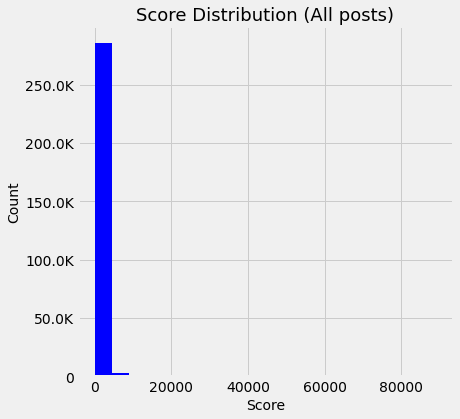

In [0]:
#Creating a graph to see distribution of score among posts
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [6, 6]
plt.style.use('fivethirtyeight')
hist(ax, sub_nba.select('score'), bins=20, color=['blue'])
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.set_title('Score Distribution (All posts)', fontsize=18)

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'score_distribution.png')
plt.savefig(plot_fpath)

plt.show()

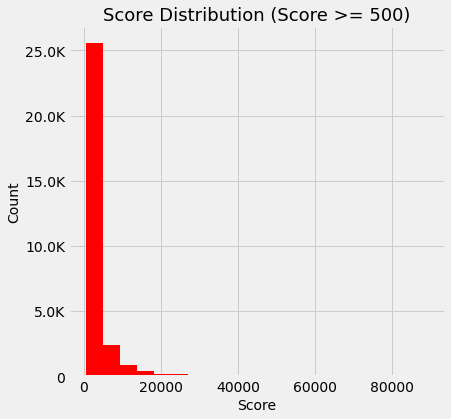

In [0]:
#Creating a graph to evaluate distribution of posts where the score is greater than 500
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [6, 6]
hist(ax, sub_nba.filter(sub_nba.score >= 500).select('score'), bins=20, color=['red'])
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.set_title('Score Distribution (Score >= 500)', fontsize=18)

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'score500_distribution.png')
plt.savefig(plot_fpath)

plt.show()

As demonstrated via the histogram plots, the vast majority of posts have a low score.
Much of the analysis, therefore, can be addressed to answer these two questions:
1) What characterizes popular vs. unpopular posts?
2) What characterizes somewhat vs. extremely popular posts?

Let's look at the top 10 posts in the `nba` subreddit using the `score` metric.

In [0]:
top_ten_posts = sub_nba.sort(sub_nba.score.desc()).limit(10).toPandas()
top_ten_posts

# save the results to csv
fpath = os.path.join(CSV_DIR, "top_ten_posts.csv")
top_ten_posts.to_csv(fpath)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field crosspost_parent_list. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('approved_at_utc', StringType(), True), StructField('approved_by', StringType(), True), StructField('archived', BooleanType(), True), StructField('author', StringType(), True), StructField('author_flair_css_class', StringType(), True), StructField('author_flair_text', StringType(), True), StructField('banned_at_utc', StringType(), True), StructField('banned_by', StringType(), True), StructField('brand_safe', BooleanType(), True), StructField('can_gild', BooleanType(), True), StructField('can_mod_post', BooleanType(),

In [0]:
view_cols = [
    'author',
    'created_utc',
    'is_reddit_media_domain',
    'title',
    'score',
    'num_comments',
    'num_crossposts',
    'subreddit',
    'url',
    'gilded',
    'whitelist_status'
]

top_ten_posts[view_cols].head(10)

,author,created_utc,is_reddit_media_domain,title,score,num_comments,num_crossposts,subreddit,url,gilded,whitelist_status
0,ThatsSoMerlyn_x3,1651446094,False,I analyzed James Harden's performance in every...,89133,4227,37,nba,https://www.reddit.com/r/nba/comments/dt0ucg/i...,51,all_ads
1,CommercialBig7008,1650293994,False,I analyzed James Harden's performance in every...,89124,4227,37,nba,https://www.reddit.com/r/nba/comments/dt0ucg/i...,51,all_ads
2,justic3bon3r,1615791417,False,I analyzed James Harden's performance in every...,89101,4244,35,nba,https://www.reddit.com/r/nba/comments/dt0ucg/i...,51,all_ads
3,Balls_of_Adamanthium,1653435457,False,Steve Kerr gives a very heated speech about th...,87527,7582,19,nba,https://streamable.com/az6lzj,18,all_ads
4,Puzzled_Influence985,1657984217,False,Charles Barkley: “If you are gay or transgende...,77112,2611,22,nba,https://streamable.com/47poyw,3,all_ads
5,GuyCarbonneauGOAT,1639849617,False,[Charania] Nets star Kyrie Irving has entered ...,72935,5333,9,nba,https://twitter.com/ShamsCharania/status/14722...,30,all_ads
6,Nyhrox,1610031820,False,Draymond Green on last night's Capitol breach:...,67709,4454,5,nba,https://streamable.com/d0s3uy,2,all_ads
7,Apollo611,1609998944,False,"[Jaylen Brown] “In one America, you get killed...",59082,3361,7,nba,https://streamable.com/svnx3y,2,all_ads
8,deadskin,1627399323,False,[Scipioni] NBA legend Charles Barkley: ‘The on...,56544,5252,7,nba,https://www.cnbc.com/2021/07/27/charles-barkle...,1,all_ads
9,132joker,1649222569,False,THE LOS ANGELES LAKERS HAVE BEEN ELIMINATED FR...,53292,4523,4,nba,https://www.reddit.com/r/nba/comments/txe77e/t...,7,all_ads


####
Perhaps unsurprisingly, all of the top posts mention a popular player/team, have some inflamitory quote/language, or both.

A quick look at the urls listed will also show that many posts include links to videos.<br>
We also see that the ten posts listed above tend to have a fair amount of crossposts.<br>
It's hard to see how the time of posting is related to the score from the timestamp, but this could be explored further.<br>
On reddit, users may spend real money to attach a badge to a post and label it `gilded`. 
It would be interesting to see if this 'gilded' label has any affect on popularity. <br>
We may also wonder if past performance (score by user) is indicative of future success.  <br>

<b>Let's examine:</b><br>
<b>1)  How/If `num_crossposts` is correlated with `score`. </b><br>
<b>2)  How much the url linking to a video influences the popularity of a post. </b><br>
<b>3)  How/If the time of posting is relevant to its popularity. </b><br>
<b>4)  If gilded posts tend to be more popular. </b><br>
<b>5)  If users who have had popular posts in the past are more likely to have popular posts in the future. </b><br>

We will categorize popular posts as those containing a score of 500 or greater as a comparison point for this analysis.

#####`num_crossposts` vs. `score`

In [0]:
#Evaluating the correlation between num_crossposts and score for posts with score greater than 500, and all posts
keep_cols = ['author', 'title', 'created_utc', 'score', 'num_crossposts']

df_cp_all = sub_nba.select(*keep_cols).cache()
df_cp_pop = sub_nba.filter(sub_nba.score >= 500).select(*keep_cols).cache()
corr_all = df_cp_all.corr('num_crossposts', 'score', method='pearson')
corr_pop = df_cp_pop.corr('num_crossposts', 'score', method='pearson')

print(BOLD(f'Pearson correlation between number of crossposts and score for all posts:               {corr_all}'))
print(BOLD(f'Pearson correlation between number of crossposts and score for posts with score >= 500: {corr_pop}'))

Pearson correlation between number of crossposts and score for all posts:               0.5908945333105224]
Pearson correlation between number of crossposts and score for posts with score >= 500: 0.5917023353210491]


The pearson correlation metrics indicate that score and number of crossposts are moderately correlated. <br>
This is perhaps unsurprising given popular posts seem more likely to be shared, but nonetheless it is still an interesting finding.

##### Does including video links within posts lead to higher popularity?

In [0]:
keep_cols = ['author', 'title', 'created_utc', 'score', 'url', 'is_video']
videos_df = sub_nba.select(*keep_cols).cache()

#Utilizing regex to create a dummy variable to determine if a link is a video or not
video_regex = '(?i)youtube|(?i)youtu.be|(?i)mp4|(?i)mov|(?i)streamable'
videos_df = videos_df.withColumn('has_video', (videos_df['url'].rlike(video_regex) | videos_df['is_video']).cast('int'))

In [0]:
videos_df_all = videos_df
videos_df_pop = videos_df_all.filter(videos_df_all.score >= 500)

corr_all = videos_df_all.corr('has_video', 'score', method='pearson')
corr_pop = videos_df_pop.corr('has_video', 'score', method='pearson')

print(BOLD(f'Pearson correlation between nba posts having a video vs not and score for all posts:               {corr_all}'))
print(BOLD(f'Pearson correlation between nba posts having a video vs not and score for posts with score >= 500: {corr_pop}'))
print()
print(BOLD(f'Percentage of all posts with linked video: {100 * videos_df_all.filter(videos_df_all.has_video == 1).count() / videos_df_all.count()}%'))
print(BOLD(f'Percentage of all posts with score >=500 and linked video: {100 * videos_df_pop.filter(videos_df_pop.has_video == 1).count() / videos_df_pop.count()}%'))

Pearson correlation between nba posts having a video vs not and score for all posts:               0.06227040688140735]
Pearson correlation between nba posts having a video vs not and score for posts with score >= 500: -0.018767589798361073]

Percentage of all posts with linked video: 17.16254543451922%]
Percentage of all posts with score >=500 and linked video: 30.843850698174005%]


There doesn't seem to be a correlation between having an associated video link and a higher score. <br>
That being said, we can also see that popular posts with a score greater than 500 have a slightly higher correlation between linked videos and score.  <br>

##### Time of Posting vs Popularity

In [0]:
keep_cols = ['author', 'title', 'created_utc', 'score']
time_df = sub_nba.select(*keep_cols).cache()

## Convert to EST datetime
time_df = time_df.withColumn('datetime', from_unixtime(time_df.created_utc) - expr("INTERVAL 5 HOURS"))

time_df.show(10)

+--------------------+--------------------+-----------+-----+-------------------+
|              author|               title|created_utc|score|           datetime|
+--------------------+--------------------+-----------+-----+-------------------+
|         BoomBoom156|How many years do...| 1614066963|   10|2021-02-23 02:56:03|
|           atlas2077|What’s wrong with...| 1614067460|    0|2021-02-23 03:04:20|
|           [deleted]|Lebron James Lowl...| 1614067586|    1|2021-02-23 03:06:26|
|           [deleted]|Lebron James lowl...| 1614067708|    2|2021-02-23 03:08:28|
|Pristine-Tomorrow318|ok trade rpators ...| 1614067717|    1|2021-02-23 03:08:37|
|             shaad20|[Highlight] The P...| 1614067878|  134|2021-02-23 03:11:18|
|           [deleted]|Is the Eastern Co...| 1614068531|    0|2021-02-23 03:22:11|
|Albus-PWB-Dumbledore|If you're whichev...| 1614069004|   19|2021-02-23 03:30:04|
|           [deleted]|[Highlight] The J...| 1614069069|    1|2021-02-23 03:31:09|
|             sh

Let's create subcolumns to see if the success of a post is correlated with:<br>

<b>1) The hour of posting (9-5, 5-10, 10-9)</b><br>
<b>2) The day of posting (weekday vs weekend(count Friday as weekend))</b><br>
<b>3) The season of posting (summer, winter, fall, spring)</b>

NOTE: For now we are simply assuming EST, as we can assume that subreddits surrounding American sports with posts in English are primarily originated in the US (Will need to verify the validity of this statement in the future). <br>
      Because US time zones are relatively close to one another, and the time slots we generated here are relatively large, differences in time zones that may not be EST should be negligible.

In [0]:
@udf
def time_of_day_mapping(hour):
    if hour < 9:
        return 'sleep_hours'
    elif hour >=9 and hour <= 17:
        return 'workday'
    else:
        return 'afternoon'

@udf
def _is_weekday(day_of_week):
    if day_of_week == 1 or day_of_week == 7:
        return 'weekend'
    return 'weekday'

@udf
def get_season(month):
    month = (month + 1) // 4
    if month == 0:
        return 'winter'
    elif month == 1:
        return 'spring'
    elif month == 2:
        return 'summer'
    return 'fall'

 #CREATING NEW VARIABLES
time_df = time_df.withColumn('time_of_day', time_of_day_mapping(hour(time_df.datetime)))
time_df = time_df.withColumn('is_weekday', _is_weekday(dayofweek(time_df.datetime)))
time_df = time_df.withColumn('season', get_season(month(time_df.datetime)))

time_df.show()

+--------------------+--------------------+-----------+-----+-------------------+-----------+----------+------+
|              author|               title|created_utc|score|           datetime|time_of_day|is_weekday|season|
+--------------------+--------------------+-----------+-----+-------------------+-----------+----------+------+
|         BoomBoom156|How many years do...| 1614066963|   10|2021-02-23 02:56:03|sleep_hours|   weekday|winter|
|           atlas2077|What’s wrong with...| 1614067460|    0|2021-02-23 03:04:20|sleep_hours|   weekday|winter|
|           [deleted]|Lebron James Lowl...| 1614067586|    1|2021-02-23 03:06:26|sleep_hours|   weekday|winter|
|           [deleted]|Lebron James lowl...| 1614067708|    2|2021-02-23 03:08:28|sleep_hours|   weekday|winter|
|Pristine-Tomorrow318|ok trade rpators ...| 1614067717|    1|2021-02-23 03:08:37|sleep_hours|   weekday|winter|
|             shaad20|[Highlight] The P...| 1614067878|  134|2021-02-23 03:11:18|sleep_hours|   weekday|

In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "time_df.csv")
time_df.toPandas().to_csv(fpath)

Let's plot the average scores for each category of these variables now.

In [0]:
groupby_cols = ['time_of_day', 'is_weekday', 'season']

avg_scores_by_tod = time_df.groupBy(groupby_cols[0]).avg('score').toPandas()
avg_scores_by_tow = time_df.groupBy(groupby_cols[1]).avg('score').toPandas()
avg_scores_by_toy = time_df.groupBy(groupby_cols[2]).avg('score').toPandas()

all_avg_scores_grouped = pd.concat([avg_scores_by_tod, avg_scores_by_tow, avg_scores_by_toy], axis=1)

avg_scores_by_tod.set_index('time_of_day', inplace=True)
avg_scores_by_tow.set_index('is_weekday', inplace=True)
avg_scores_by_toy.set_index('season', inplace=True)

#SUMMARY TABLE:
all_avg_scores_grouped

,time_of_day,avg(score),is_weekday,avg(score),season,avg(score)
0,afternoon,380.528875,weekday,347.421050,winter,303.811807
1,sleep_hours,269.585093,weekend,329.378747,spring,341.759971
2,workday,341.394642,NaN,NaN,summer,364.281302
3,NaN,NaN,NaN,NaN,fall,383.008148


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "all_avg_scores_grouped.csv")
all_avg_scores_grouped.to_csv(fpath)

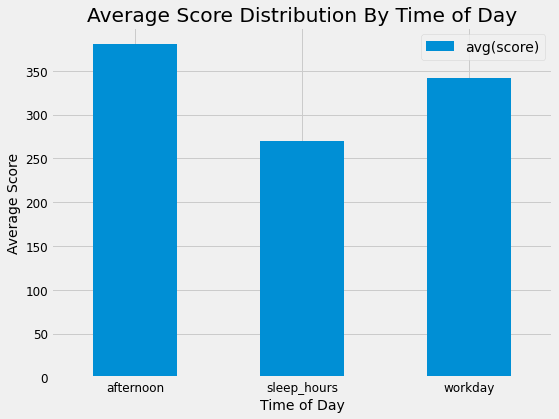

In [0]:
avg_scores_by_tod.plot.bar(title='Average Score Distribution By Time of Day', fontsize=12)
plt.rcParams['figure.figsize'] = [8, 6]
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation = 0)
# for i in range(0,3):
#     plt.annotate(avg_scores_by_tod['avg(score)'][i], xy=(avg_scores_by_tod.index.values[i],avg_scores_by_tod['avg(score)'][i]), ha='center', va='bottom')
## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'average_score_distribution_by_time_of_day.png')
plt.savefig(plot_fpath)
plt.show()

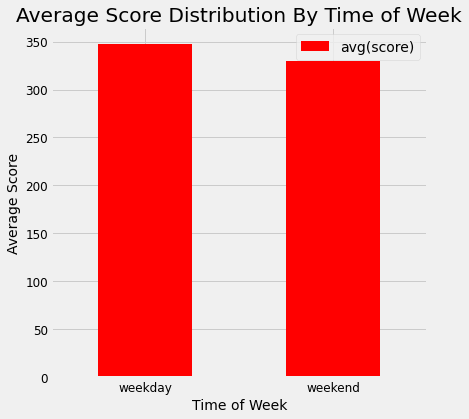

In [0]:
avg_scores_by_tow.plot.bar(title='Average Score Distribution By Time of Week', fontsize=12, colormap='autumn')
plt.rcParams['figure.figsize'] = [6, 6]
plt.xlabel('Time of Week', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation = 0)
plot_fpath = os.path.join(PLOT_DIR, 'average_score_distribution_by_time_of_week.png')
plt.savefig(plot_fpath)
plt.show()

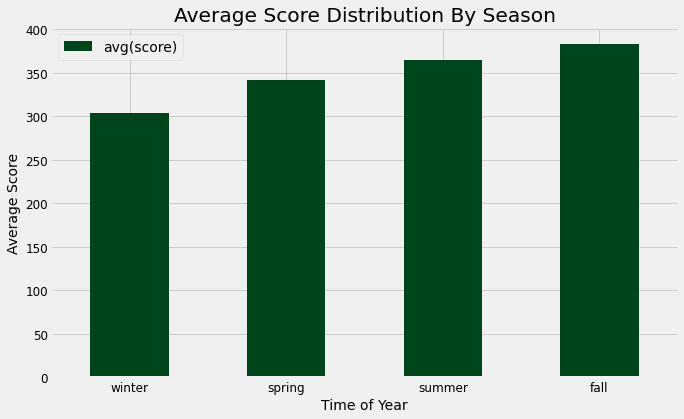

In [0]:
avg_scores_by_toy.plot.bar(title='Average Score Distribution By Season', fontsize=12, colormap='Greens_r')
plt.rcParams['figure.figsize'] = [10, 6]
plt.xlabel('Time of Year', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation = 0)
plot_fpath = os.path.join(PLOT_DIR, 'average_score_distribution_by_time_of_season.png')
plt.savefig(plot_fpath)
plt.show()

The graphs seem to indicate that the time of day and time of year could be influential factors in determining the popularity of a post. <br>
However, in order to statistically verify this observation, we would need to perform further analyses, such as conducting t-tests and chi-squared tests.

#####Gilded Status vs Score

As previously mentioned, users are allowed to spend real money to imbue a post with a gilded medal. (See https://www.howtogeek.com/447142/what-is-reddit-gold-and-why-would-you-want-it/#:~:text=3%20min%20read-,Reddit,the%20poster%20with%20Reddit%20Gold.)<br>
We would like to see if this has any impact on popularity.

In [0]:
keep_cols = ['author', 'title', 'created_utc', 'gilded', 'score']
gilded_df = sub_nba.select(*keep_cols).cache()

#SUMMARY TABLE
gilded_df.groupBy('gilded').count().show()

+------+------+
|gilded| count|
+------+------+
|     0|288556|
|     1|  1666|
|     2|   179|
|     3|    66|
|    18|     2|
|     4|    30|
|     6|     3|
|     5|     3|
|     7|     9|
|     8|     4|
|     9|     4|
|    51|     3|
|    14|     1|
|    15|     1|
|    30|     1|
+------+------+



In [0]:
# save the results to csv
gilded_count = gilded_df.groupBy('gilded').count()
fpath = os.path.join(CSV_DIR, "gilded_count.csv")
gilded_count.toPandas().to_csv(fpath)

We can see already that the vast majority of posts do not have a gilded status. <br>
Given these guilds are fairly scarce, does receiving a gilded status lead to higher popularity for a post? <br><br>
It is also worth noting that a post that is already popular in the first place is much more likely to receive a gilded status due to increased exposure, rather than the other way around. <br>
While we cannot tell from directly from this data, we can at least examine the distributions of `score`'s among gilded and non-gilded posts.

In [0]:
gilded_df = gilded_df.withColumn('is_gilded', gilded_df.gilded.cast('boolean'))

avg_scores_by_gilded = gilded_df.groupBy('is_gilded').avg('score').toPandas()

avg_scores_by_gilded.set_index('is_gilded', inplace=True)

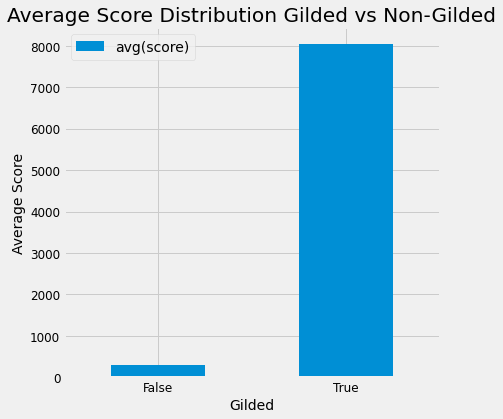

In [0]:
avg_scores_by_gilded.plot.bar(title='Average Score Distribution Gilded vs Non-Gilded', fontsize=12)
plt.rcParams['figure.figsize'] = [6, 6]
plt.xlabel('Gilded', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation = 0)
plot_fpath = os.path.join(PLOT_DIR, 'average_score_distribution_gilded_nongilded.png')
plt.savefig(plot_fpath)
plt.show()

Clearly there is a sizabe difference in the distribution of scores. This suggests that either "gilding" a post <br>
is an effective way to increase its popularity, or simply that popular posts are much more likely to get guilded due to exposure. <br>
The latter seems more likely, although further investigation would be necessary to reach a definite conclusion.

#####Past Success vs Future Performance
To evaluate whether past success is indicative of future performance, let's create a field enumerating <br>
the total score per user over the entirety of the time period listed within the `nba` subreddit.

In [0]:
keep_cols = ['author', 'title', 'created_utc', 'score']
agg_user_df = sub_nba.select(*keep_cols).filter(sub_nba.author != '[deleted]').cache()

windowval     = (Window.partitionBy('author').orderBy('created_utc').rangeBetween(Window.unboundedPreceding, 0))
agg_scores_df = agg_user_df.withColumn('aggregate_score', sum('score').over(windowval))

agg_scores_df.show(10)

+----------------+--------------------+-----------+-----+---------------+
|          author|               title|created_utc|score|aggregate_score|
+----------------+--------------------+-----------+-----+---------------+
|        -Laefuu-|Guy Kevin is iver...| 1659301348|    0|              0|
|  -Nelson-Muntz-|The Grizzlies blo...| 1638522066|35246|          35246|
|-Richard_Parker-|An Overly Complic...| 1620677148|    1|              1|
|          -SKV--|Is this weakest n...| 1618602500|    0|              0|
|           0-2er|Link to stream of...| 1626969277|    2|              2|
|           0-2er|NBA players have ...| 1651004673|    1|              3|
|         0patty6|Denver almost had...| 1619225804|    1|              1|
|  101Marketplace|Anyone find it cr...| 1617432378|    0|              0|
|   12InchBabyArm|Best point guard ...| 1614587830|    0|              0|
|           22bor|Khris "Ice in his...| 1624897000|  285|            285|
+----------------+--------------------

Now let's calculate the pearson correlation between `score` and `aggregate_score`.

In [0]:
corr_all = agg_scores_df.corr('aggregate_score', 'score', method='pearson')
print(BOLD(f'Pearson correlation between aggregate score and score is: {corr_all})'))

Pearson correlation between aggregate score and score is: 0.1682166513512577)


We see that there is a (somewhat weak) positive correlation between aggregate score and performance. <br>
It could be, however, that users' overall quantity of posting is in fact more important than their aggregate score in predicting future performance. <br>
On that note, let's repeat the analysis, but instead see if `num_posts` is correlated with `score`.

In [0]:
keep_cols = ['author', 'title', 'created_utc', 'score']
agg_user_df = sub_nba.select(*keep_cols).filter(sub_nba.author != '[deleted]').cache()

windowval     = (Window.partitionBy('author').orderBy('created_utc').rangeBetween(Window.unboundedPreceding, 0))
agg_scores_df = agg_user_df.withColumn('num_posts', count('score').over(windowval))

agg_scores_df.show(10)

+------------+--------------------+-----------+-----+---------+
|      author|               title|created_utc|score|num_posts|
+------------+--------------------+-----------+-----+---------+
|-Danky_Kang-|Was Shaq ever nic...| 1645131077|    1|        1|
|       -HCLW|Draymon read Nick...| 1610342600|    9|        1|
|       -HCLW|Currently: NBA Ca...| 1613055382|   45|        2|
|    -Mr_Tub-|Who are the bigge...| 1624292541|    0|        1|
|    -Mr_Tub-|What are some tra...| 1624419919|    1|        2|
|    -Mr_Tub-|What are some tra...| 1624420101|    0|        3|
|    -Mr_Tub-|Each playoff team...| 1625846456|    5|        4|
|     027eddy|Bobby Portis inte...| 1626975497|  420|        1|
|     027eddy|Michael Porter Jr...| 1644699896| 3661|        2|
|     027eddy|Giannis feels ter...| 1645427963| 2084|        3|
+------------+--------------------+-----------+-----+---------+
only showing top 10 rows



In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "agg_scores_df.csv")
agg_scores_df.toPandas().to_csv(fpath)

In [0]:
corr_all = agg_scores_df.corr('num_posts', 'score', method='pearson')

print(BOLD(f'Pearson correlation between number of posts by user and score is: {corr_all}'))

Pearson correlation between number of posts by user and score is: 0.08876683538728454


Very interesting! We can see that there seems to be a <i>weaker</i> correlation between number of posts and `score`. <br>
Taken in conjunction with the previous finding, we can start to speculate that the aggregate score rather than number of posts is a better indicator of performance.

### Analyzing whether a team's performance has an impact on their subreddit's popularity - preliminary steps<br>
Up to this point, we've conducted analysis on what factors impact the popularity of reddit posts utilizing the NBA subreddit. <br>
These findings from the can extrapolated to other sports' subreddits, and likely to all subreddits in general. <br>

However, at this point we will shift our focus to the NFL subreddit to begin tackling a more specifc question: Are posts within a subreddit generally more popular for teams that are performing well?<br>
Analyzing this question could not only have interesting implications for understanding factors leading to posts' popularity, but it could also be illustrative of how improving a team's performance leads <br>
to a more active and engaged fanbase.

### Extract subreddits of 32 NFL teams and more

In [0]:
filter_values_list = ['nfl','fantasyfootball','bengals','Browns','ravens','steelers','Tennesseetitans','Texans','Colts','Jaguars','Patriots','buffalobills','miamidolphins','nyjets','KansasCityChiefs','DenverBroncos','Chargers','raiders','minnesotavikings','GreenBayPackers','CHIBears','detroitlions','buccaneers','Saints','panthers','falcons','NYGiants','cowboys','eagles','Commanders','49ers','Seahawks','LosAngelesRams','AZCardinals']
#test = submissions.filter((submissions.subreddit == "bengals") | (submissions.subreddit == "Browns") | (submissions.subreddit == "ravens") | (submissions.subreddit == "steelers")).cache()

In [0]:
sports_submission = submissions.filter(submissions.subreddit.isin(filter_values_list))

In [0]:
sports_submission.select('subreddit').show(5)

+---------+
|subreddit|
+---------+
|   nyjets|
|      nfl|
|      nfl|
| Seahawks|
| CHIBears|
+---------+
only showing top 5 rows



### Save the sports data to FileStore

In [0]:
sports_submission.write.parquet("/FileStore/sports/sports_submission_submission.parquet")

In [0]:
sports_submission = sports_submission.groupBy("subreddit").count().orderBy(col("count"), ascending=False).collect()
sports_submission

Out[115]: [Row(subreddit='nfl', count=170392),
 Row(subreddit='fantasyfootball', count=83689),
 Row(subreddit='GreenBayPackers', count=31391),
 Row(subreddit='49ers', count=28526),
 Row(subreddit='bengals', count=27932),
 Row(subreddit='raiders', count=26458),
 Row(subreddit='CHIBears', count=26141),
 Row(subreddit='steelers', count=26075),
 Row(subreddit='Patriots', count=26029),
 Row(subreddit='buffalobills', count=26009),
 Row(subreddit='ravens', count=25598),
 Row(subreddit='detroitlions', count=24221),
 Row(subreddit='minnesotavikings', count=24138),
 Row(subreddit='DenverBroncos', count=23272),
 Row(subreddit='Colts', count=21781),
 Row(subreddit='Browns', count=21708),
 Row(subreddit='miamidolphins', count=21089),
 Row(subreddit='eagles', count=20426),
 Row(subreddit='LosAngelesRams', count=18916),
 Row(subreddit='KansasCityChiefs', count=17176),
 Row(subreddit='buccaneers', count=17063),
 Row(subreddit='nyjets', count=16987),
 Row(subreddit='Chargers', count=16984),
 Row(subred

### Create a table of total submission count of each NFL team subreddit

In [0]:
tbl_sports = spark.createDataFrame(sports_submission[2:]).toPandas() #slice out r/NFL and r/fantacyfootball subreddits
#SUMMARY TABLE
tbl_sports.head(10)

,subreddit,count
0,GreenBayPackers,31391
1,49ers,28526
2,bengals,27932
3,raiders,26458
4,CHIBears,26141
5,steelers,26075
6,Patriots,26029
7,buffalobills,26009
8,ravens,25598
9,detroitlions,24221


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "tbl_sports.csv")
tbl_sports.to_csv(fpath)

### Plot a histogram on submission count by each NFL team subreddit

<command-2825869844743092>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(y[i]+1000, x[i],y[i], ha = 'center',


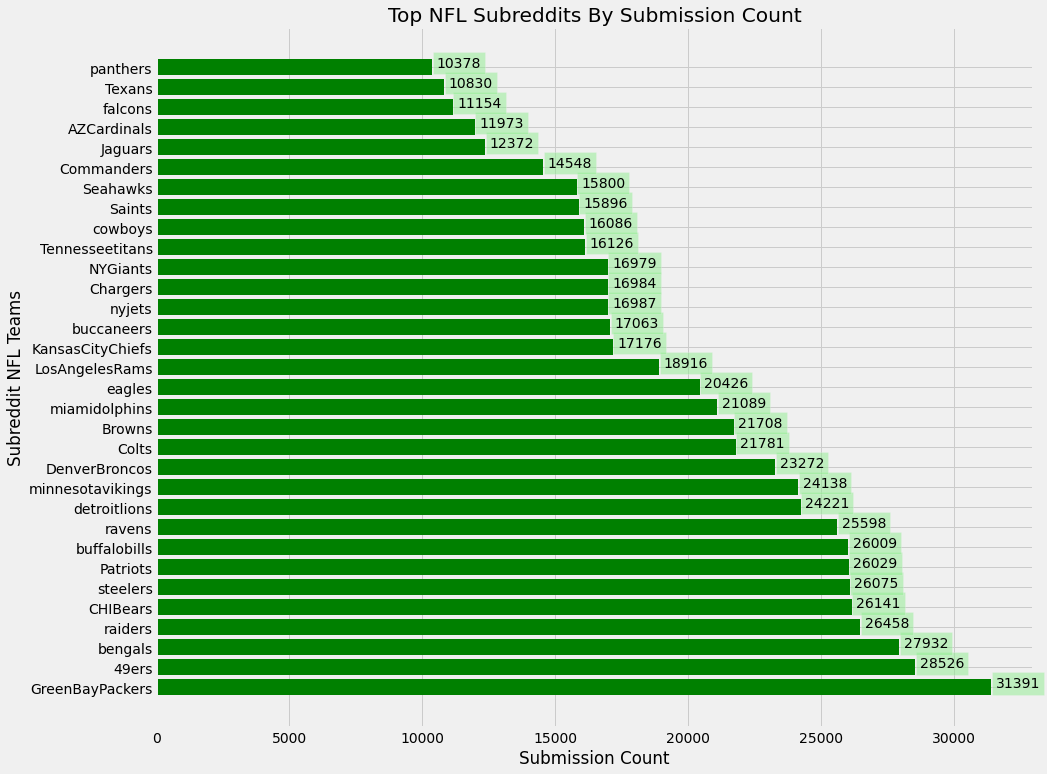

In [0]:
## Import data visualization packages
import matplotlib.pyplot as plt
from matplotlib import style
        
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(y[i]+1000, x[i],y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightgreen', alpha = .5))
# Using the style for the plot
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 12]
plt.barh("subreddit","count", data=tbl_sports, color='green')
addlabels(tbl_sports['subreddit'], tbl_sports['count'])
plt.ylabel("Subreddit NFL Teams")
plt.xlabel("Submission Count")
plt.title('Top NFL Subreddits By Submission Count')

# Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'top_nfl_subreddits_by_submission_count.png')
plt.savefig(plot_fpath)
plt.show()

This graph provides an overview demonstrating which NFL teams have the most active subreddits by utilizing submission count as the metric. <br>
There are some indicators in this graph that teams that perform better have higher popularity, with subreddits for historically good teams like <br>
the Packers and Patriots each having high submission counts.

Interestingly, some teams with massively large fanbases, such as the Cowboys, have a noticably lower overall submission count than teams <br>
with signficantly smaller fanbases, such as the Bengals. An obvious explanation for this is that perhaps subreddits with a <br>
higher submission count have existed for a longer period of time than those with a lower submission count, and fanbase is not as significant of a factor. <br>
This seems unlikely, however, since it would logically follow that a team with a more engaged fanbase would have fans that would be more likely to create a subreddit at an earlier date.

In our future analysis, we will link data about these subreddits with external NFL data, such as team performance, to provide further insight into this question. <br>
Futher statistical analysis would be necessary to dive deeper into each of these specific questions raised.

###Comparison With Other Sports Related Subreddits
<b>We will now shift our focus to compare the NBA and NFL subreddits that we have previously analyzed. <br>
  We will see if similar factors influence post popularity by first examining and comparing timing of posts between the two subreddits.

Perhaps a feature which would most likely vary in determining post popularity would be the posting time. <br>
We might expect posts to be more popular during the peaks of their season, on certain common game days (Sunday for NFL perhaps), <br>
and perhaps even at different times of day for different sports. However, we could very well find that there is little variation <br>
between subreddits and that time of posting is largely unimportant. Let's start by aggregating the `nfl` subreddit's data and <br>
creating a few new features.

In [0]:
nfl_submissions = spark.read.parquet("/FileStore/sports/sports_submission_submission.parquet")

## check for missing data for created_utc
missing = nfl_submissions.select([count(when(col("created_utc").contains('None') | \
                            col("created_utc").contains('NULL') | \
                            (col("created_utc") == '' ) | \
                            col("created_utc").isNull() | \
                            isnan("created_utc"), "created_utc" 
                           )).alias("created_utc")])
missing.show()


nba_submissions = sub_nba

## check for missing data for created_utc
missing = nba_submissions.select([count(when(col("created_utc").contains('None') | \
                            col("created_utc").contains('NULL') | \
                            (col("created_utc") == '' ) | \
                            col("created_utc").isNull() | \
                            isnan("created_utc"), "created_utc" 
                           )).alias("created_utc")])
missing.show()

+-----------+
|created_utc|
+-----------+
|          0|
+-----------+

+-----------+
|created_utc|
+-----------+
|          0|
+-----------+



Let's first again summarize the `nfl` and `nba` subreddit's posts by time of posting.

In [0]:
## convert unix time to timestamp
nfl_submissions = nfl_submissions.withColumn("created_utc", from_unixtime(col("created_utc")))
nba_submissions = nba_submissions.withColumn("created_utc", from_unixtime(col("created_utc")))

In [0]:
## Create new variables including time_slot, dayofweek, and post_month according to "create_utc" column.

nfl_submissions = nfl_submissions.withColumn("time_slot", 
    when(hour(col('created_utc')).isin([0,1,2]), "00:00-03:00")
    .when(hour(col('created_utc')).isin([3,4,5]), "03:00-06:00")
    .when(hour(col('created_utc')).isin([6,7,8]), "06:00-09:00")
    .when(hour(col('created_utc')).isin([9,10,11]), "09:00-12:00")
    .when(hour(col('created_utc')).isin([12,13,14]), "12:00-15:00")
    .when(hour(col('created_utc')).isin([15,16,17]), "15:00-18:00")
    .when(hour(col('created_utc')).isin([18,19,20]), "18:00-21:00")  
    .when(hour(col('created_utc')).isin([21,22,23]), "21:00-00:00")
    .otherwise(0))\
.withColumn("dayofweek", date_format('created_utc', 'E'))\
.withColumn("post_month", date_format(col("created_utc"), 'MMMM'))


nba_submissions = nba_submissions.withColumn("time_slot", 
    when(hour(col('created_utc')).isin([0,1,2]), "00:00-03:00")
    .when(hour(col('created_utc')).isin([3,4,5]), "03:00-06:00")
    .when(hour(col('created_utc')).isin([6,7,8]), "06:00-09:00")
    .when(hour(col('created_utc')).isin([9,10,11]), "09:00-12:00")
    .when(hour(col('created_utc')).isin([12,13,14]), "12:00-15:00")
    .when(hour(col('created_utc')).isin([15,16,17]), "15:00-18:00")
    .when(hour(col('created_utc')).isin([18,19,20]), "18:00-21:00")  
    .when(hour(col('created_utc')).isin([21,22,23]), "21:00-00:00")
    .otherwise(0))\
.withColumn("dayofweek", date_format('created_utc', 'E'))\
.withColumn("post_month", date_format(col("created_utc"), 'MMMM'))

We again will not consider different time zones. We instead will simply focus on whether there are different overall optimal times of posting, which is independent of a specific time zone.

In [0]:
nfl_posttime = nfl_submissions.select(col('created_utc'), col("time_slot"), col("dayofweek"), col("post_month"))
nba_posttime = nba_submissions.select(col('created_utc'), col("time_slot"), col("dayofweek"), col("post_month"))

nfl_posttime.show(5)
nba_posttime.show(5)

+-------------------+-----------+---------+----------+
|        created_utc|  time_slot|dayofweek|post_month|
+-------------------+-----------+---------+----------+
|2021-10-13 16:49:25|15:00-18:00|      Wed|   October|
|2021-10-13 16:49:33|15:00-18:00|      Wed|   October|
|2021-10-13 16:49:34|15:00-18:00|      Wed|   October|
|2021-10-13 16:50:05|15:00-18:00|      Wed|   October|
|2021-10-13 16:50:38|15:00-18:00|      Wed|   October|
+-------------------+-----------+---------+----------+
only showing top 5 rows

+-------------------+-----------+---------+----------+
|        created_utc|  time_slot|dayofweek|post_month|
+-------------------+-----------+---------+----------+
|2021-02-23 07:56:03|06:00-09:00|      Tue|  February|
|2021-02-23 08:04:20|06:00-09:00|      Tue|  February|
|2021-02-23 08:06:26|06:00-09:00|      Tue|  February|
|2021-02-23 08:08:28|06:00-09:00|      Tue|  February|
|2021-02-23 08:08:37|06:00-09:00|      Tue|  February|
+-------------------+-----------+-------

In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "nfl_posttime.csv")
nfl_posttime.toPandas().to_csv(fpath)

fpath = os.path.join(CSV_DIR, "nba_posttime.csv")
nba_posttime.toPandas().to_csv(fpath)

In [0]:
nfl_timeslot_summary = nfl_submissions.groupBy('time_slot').count().toPandas()
nba_timeslot_summary = nba_submissions.groupBy('time_slot').count().toPandas()

nfl_timeslot_summary['sort_idx'] = nfl_timeslot_summary['time_slot'].apply(lambda x: int(x[:2]))
nba_timeslot_summary['sort_idx'] = nba_timeslot_summary['time_slot'].apply(lambda x: int(x[:2]))

nfl_timeslot_summary = nfl_timeslot_summary.sort_values('sort_idx').drop(columns='sort_idx')
nba_timeslot_summary = nba_timeslot_summary.sort_values('sort_idx').drop(columns='sort_idx')

print(nfl_timeslot_summary.head(10))
print(nba_timeslot_summary.head(10))

     time_slot   count
3  00:00-03:00  137324
5  03:00-06:00   95549
1  06:00-09:00   29754
2  09:00-12:00   28935
0  12:00-15:00   99194
4  15:00-18:00  167595
7  18:00-21:00  177319
6  21:00-00:00  158473
     time_slot  count
2  00:00-03:00  55520
6  03:00-06:00  56768
7  06:00-09:00  17417
1  09:00-12:00  10354
0  12:00-15:00  24009
3  15:00-18:00  40986
4  18:00-21:00  43384
5  21:00-00:00  42090


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "nfl_timeslot_summary.csv")
nfl_timeslot_summary.to_csv(fpath)

fpath = os.path.join(CSV_DIR, "nba_timeslot_summary.csv")
nba_timeslot_summary.to_csv(fpath)

Let's vizualize the number of posts submitted at different times for each subreddit.

<command-1029788259904362>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+6000,y[i], ha = 'center',
<command-1029788259904362>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+2000,y[i], ha = 'center',


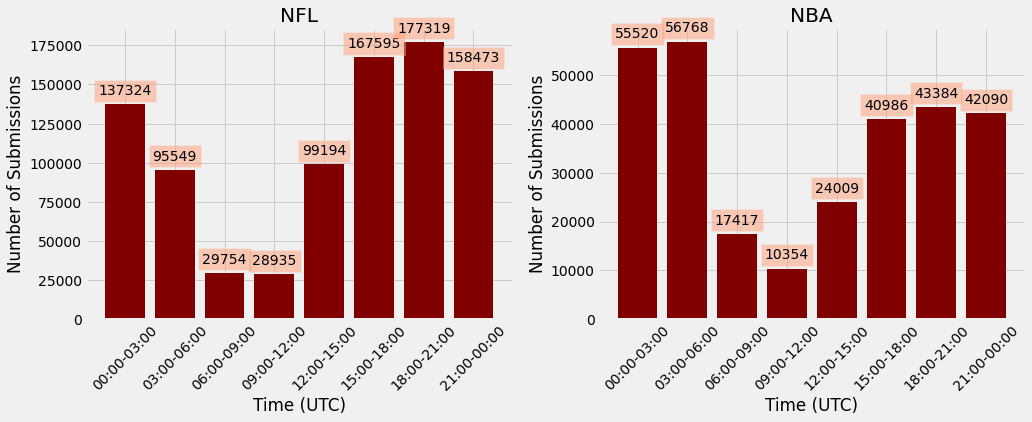

In [0]:
def addlabels_nfl(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+6000,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))
        
def addlabels_nba(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+2000,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))

fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.subplot(1, 2, 1)
plt.bar('time_slot', 'count', data=nfl_timeslot_summary, color='maroon') 
addlabels_nfl(nfl_timeslot_summary['time_slot'], nfl_timeslot_summary['count'])
plt.xlabel("Time (UTC)")
plt.xticks(rotation = 45)
plt.ylabel("Number of Submissions")
plt.title("NFL")

plt.subplot(1, 2, 2)
plt.bar('time_slot', 'count', data=nba_timeslot_summary, color='maroon') 
addlabels_nba(nba_timeslot_summary['time_slot'], nba_timeslot_summary['count'])
plt.xlabel("Time (UTC)")
plt.xticks(rotation = 45)
plt.ylabel("Number of Submissions")
plt.title("NBA")

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'comparison_submission_timeslot.png')
plt.savefig(plot_fpath)

plt.show()

The distribution seems fairly similar here, however it is possible that nba fans are active on reddit more in the night (American Time). <br>
Let's now repeat the above analysis for time of week and time of month.

####Time of Week; `nfl` vs. `nba` subreddits

In [0]:
days_of_week_mapping = {
    'Sun': 0,
    'Mon': 1,
    'Tue': 2,
    'Wed': 3,
    'Thu': 4,
    'Fri': 5,
    'Sat': 6
}

In [0]:
nfl_timeofweek_summary = nfl_submissions.groupBy('dayofweek').count().toPandas()
nba_timeofweek_summary = nba_submissions.groupBy('dayofweek').count().toPandas()

nfl_timeofweek_summary['sort_idx'] = nfl_timeofweek_summary['dayofweek'].map(days_of_week_mapping)
nba_timeofweek_summary['sort_idx'] = nba_timeofweek_summary['dayofweek'].map(days_of_week_mapping)

nfl_timeofweek_summary = nfl_timeofweek_summary.sort_values('sort_idx').drop(columns='sort_idx')
nba_timeofweek_summary = nba_timeofweek_summary.sort_values('sort_idx').drop(columns='sort_idx')

print(nfl_timeslot_summary.head(10))
print(nba_timeslot_summary.head(10))
print(nfl_timeofweek_summary.head(10))
print(nba_timeofweek_summary.head(10))

     time_slot   count
3  00:00-03:00  137324
5  03:00-06:00   95549
1  06:00-09:00   29754
2  09:00-12:00   28935
0  12:00-15:00   99194
4  15:00-18:00  167595
7  18:00-21:00  177319
6  21:00-00:00  158473
     time_slot  count
2  00:00-03:00  55520
6  03:00-06:00  56768
7  06:00-09:00  17417
1  09:00-12:00  10354
0  12:00-15:00  24009
3  15:00-18:00  40986
4  18:00-21:00  43384
5  21:00-00:00  42090
  dayofweek   count
0       Sun  141988
1       Mon  168224
5       Tue  135059
4       Wed  120922
2       Thu  114737
6       Fri  121973
3       Sat   91240
  dayofweek  count
6       Sun  37236
4       Mon  41240
5       Tue  41877
2       Wed  43827
0       Thu  46653
3       Fri  42054
1       Sat  37641


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "nfl_timeofweek_summary.csv")
nfl_timeofweek_summary.to_csv(fpath)

fpath = os.path.join(CSV_DIR, "nba_timeofweek_summary.csv")
nba_timeofweek_summary.to_csv(fpath)

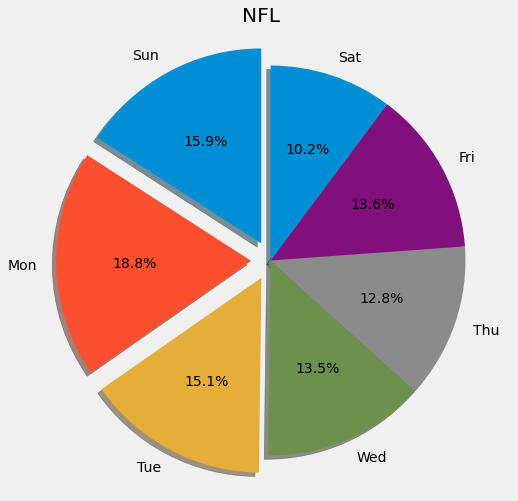

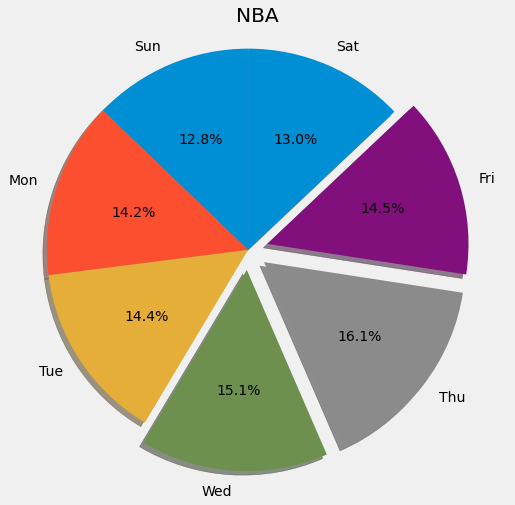

In [0]:
## Pie chart
labels1 = nfl_timeofweek_summary.dayofweek
labels2 = nba_timeofweek_summary.dayofweek

sizes1  = nfl_timeofweek_summary['count']
sizes2  = nba_timeofweek_summary['count']

explode1 = (0.1, 0.1, 0.1, 0, 0, 0, 0)  
explode2 = (0, 0, 0, 0.1, 0.1, 0.1, 0)


## NFL plot
plt.rcParams['figure.figsize'] = [8, 8]
fig1, ax1 = plt.subplots()
ax1.pie(sizes1, explode=explode1, labels=labels1, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("NFL")


## NBA plot
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, explode=explode2, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("NBA")


## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'comparison_submission_dayofweek.png')
plt.savefig(plot_fpath)
plt.show()

Unsurprisingly, we see that there is more activity on Sunday and Monday for the NFL subreddit due to games being played on those days.<br>
As we will see in a moment, this phenomenon would be even more exacerbated if the posts were isolated to the NFL season.

####Time of Year; `nfl` vs. `nba` subreddits

In [0]:
months_mapping = {
    'Jan': 0,
    'Feb': 1,
    'Mar': 2,
    'Apr': 3,
    'May': 4,
    'Jun': 5,
    'Jul': 6,
    'Aug': 7,
    'Sep': 8,
    'Oct': 9,
    'Nov': 10,
    'Dec': 11
}

In [0]:
nfl_timeslot_summary1 = nfl_submissions.groupBy('post_month').count().toPandas()
nba_timeslot_summary1 = nba_submissions.groupBy('post_month').count().toPandas()

nfl_timeslot_summary1['sort_idx'] = nfl_timeslot_summary1['post_month'].map(months_mapping)
nba_timeslot_summary1['sort_idx'] = nba_timeslot_summary1['post_month'].map(months_mapping)

nfl_timeslot_summary1 = nfl_timeslot_summary1.sort_values('sort_idx').drop(columns='sort_idx')
nba_timeslot_summary1 = nba_timeslot_summary1.sort_values('sort_idx').drop(columns='sort_idx')

print(nfl_timeslot_summary1.head(10))
print(nba_timeslot_summary1.head(10))

  post_month   count
6        May   53922
0       July   47156
1   November   62935
2   February   73361
3    January  168160
4      March   87306
5    October   69999
7     August   93359
8      April   65063
9       June   37096
  post_month  count
6        May  31661
0       July  30334
1     August  22146
2       June  37026
3      April  30803
4   February  30148
5      March  31908
7    January  31818
8  September   7941
9   December  12375


In [0]:
# re-order the month column
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

nfl_timeslot_summary1['post_month'] = pd.Categorical(nfl_timeslot_summary1['post_month'], categories=new_order, ordered=True)
nfl_timeslot_summary1.sort_values(by='post_month',inplace=True)

nba_timeslot_summary1['post_month'] = pd.Categorical(nba_timeslot_summary1['post_month'], categories=new_order, ordered=True)
nba_timeslot_summary1.sort_values(by='post_month',inplace=True)
nba_timeslot_summary1,nfl_timeslot_summary1

Out[492]: (   post_month  count
 7     January  31818
 4    February  30148
 5       March  31908
 3       April  30803
 6         May  31661
 2        June  37026
 0        July  30334
 1      August  22146
 8   September   7941
 11    October  11797
 10   November  12571
 9    December  12375,
    post_month   count
 3     January  168160
 2    February   73361
 4       March   87306
 8       April   65063
 6         May   53922
 9        June   37096
 0        July   47156
 7      August   93359
 11  September   71084
 5     October   69999
 1    November   62935
 10   December   64702)

In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "nfl_timeslot_summary1.csv")
nfl_timeslot_summary1.to_csv(fpath)

fpath = os.path.join(CSV_DIR, "nba_timeslot_summary1.csv")
nba_timeslot_summary1.to_csv(fpath)

<command-1029788259904443>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+4000,y[i], ha = 'center',
<command-1029788259904443>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+1000,y[i], ha = 'center',


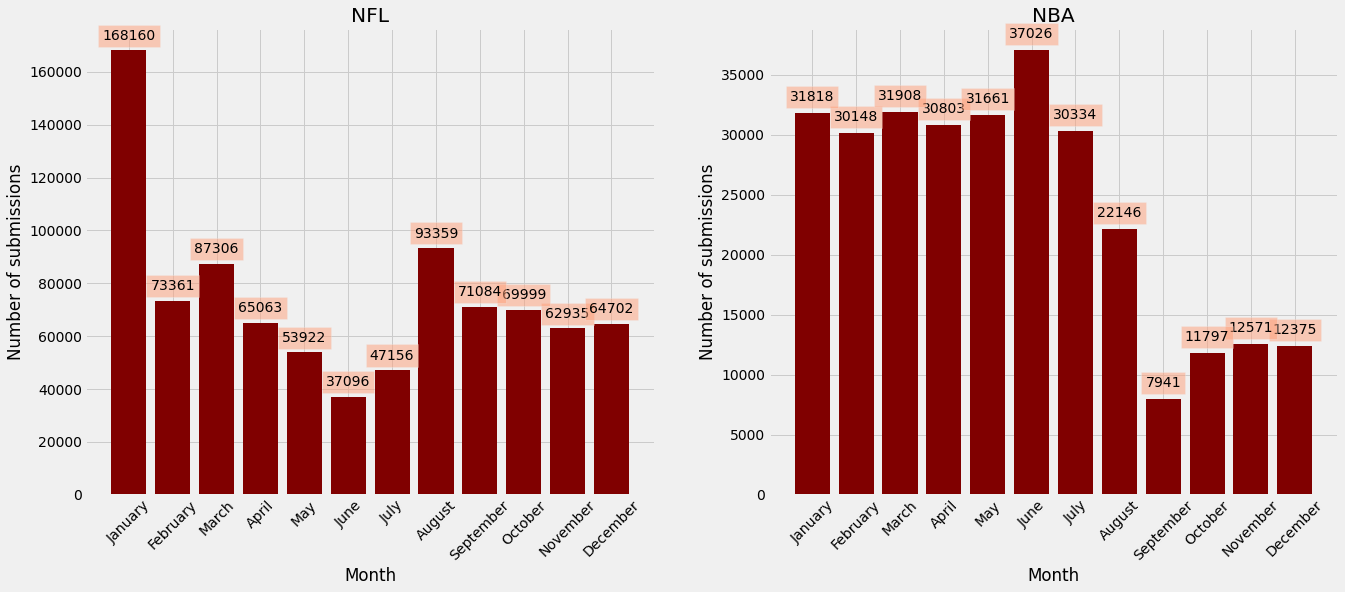

In [0]:
def addlabels_nfl(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+4000,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))
        
def addlabels_nba(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+1000,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))

# Barplot
fig = plt.figure(figsize = (20, 8))
# creating the bar plot
plt.subplot(1, 2, 1)
plt.bar('post_month', 'count', data=nfl_timeslot_summary1, color='maroon') 
addlabels_nfl(nfl_timeslot_summary1['post_month'], nfl_timeslot_summary1['count'])
plt.xlabel("Month")
plt.xticks(rotation = 45)
plt.ylabel("Number of submissions")
plt.title("NFL")

plt.subplot(1, 2, 2)
plt.bar('post_month', 'count', data=nba_timeslot_summary1, color='maroon') 
addlabels_nba(nba_timeslot_summary1['post_month'], nba_timeslot_summary1['count'])
plt.xlabel("Month")
plt.xticks(rotation = 45)
plt.ylabel("Number of submissions")
plt.title("NBA")

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'comparison_submission_month.png')
plt.savefig(plot_fpath)

plt.show()

As the NBA season is much more spread throughtout the year than that of the NFL, the plot above is not surprising. <br>
The NFL's posts reach a significant peak as the playoffs commence and the Super Bowl approaches. <br>
The same thing happens in the NBA as the championships approach in June, but it is less pronounced and less skewed.

### Comment Sentiment Analysis - Preliminary Steps/EDA <br>

While the primary focus of our analysis has been on users' submissions, for this portion of the project will shift to analyzing users' comments in order to conduct sentiment analysis. <br>
In order to conduct this senetiment analysis, we will utilize comments submitted within the NBA subreddit as a starting point. Comments regarding specific  <br>
topics or threads may be explored more in depth at a later date. 

Before conducting this analysis, we will simply view the distribution of when comments are posted during different days of the week.
This will give us a base understanding as to when users are most active. 
We can then explore as to whether the distribution of positve/negative comments differ based on the day of the week or potentially based on other time metrics as well. <br>
Knowing when users are most positive/negative in their comments could have interesting implications about how they engage with the subreddit, or even with the NBA as a whole.

In [0]:
com_nba = comments.filter(comments.subreddit == 'nba').cache()
#Filtering out comments that are less than 75 characters (roughly a sentence) as those comments will not be relevant to our sentiment analysis
com_nba = comments.filter(length(col('body')) > 75)

In [0]:
#Converting unix values to timestamp
com_nba = com_nba.withColumn("created_utc",from_unixtime(col("created_utc")))

In [0]:
#Creating specific time slots to view the data
com_nba = com_nba.withColumn("time_slot", 
    when(hour(col('created_utc')).isin([0,1,2]), "0:00-3:00")
    .when(hour(col('created_utc')).isin([3,4,5]), "3:00-6:00")
    .when(hour(col('created_utc')).isin([6,7,8]), "6:00-9:00")
    .when(hour(col('created_utc')).isin([9,10,11]), "9:00-12:00")
    .when(hour(col('created_utc')).isin([12,13,14]), "12:00-15:00")
    .when(hour(col('created_utc')).isin([15,16,17]), "15:00-18:00")
    .when(hour(col('created_utc')).isin([18,19,20]), "18:00-21:00")  
    .when(hour(col('created_utc')).isin([21,22,23]), "21:00-0:00")
    .otherwise(0))\
.withColumn("dayofweek",date_format('created_utc', 'E'))

In [0]:
com_nba_posttime = com_nba.select(col('created_utc'),col("time_slot"),col("dayofweek"))

In [0]:
com_nba_posttime.show(10)

+-------------------+---------+---------+
|        created_utc|time_slot|dayofweek|
+-------------------+---------+---------+
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
|2021-06-23 08:32:33|6:00-9:00|      Wed|
+-------------------+---------+---------+
only showing top 10 rows



In [0]:
#Grouping by the time slot
com_nba_summary = com_nba_posttime.groupBy('time_slot').count().toPandas()

In [0]:
com_nba_summary

,time_slot,count,time_order
0,9:00-12:00,158141456,4
1,12:00-15:00,254467970,5
2,15:00-18:00,325999216,6
3,18:00-21:00,319725984,2
4,21:00-0:00,291189962,3
5,6:00-9:00,155101617,7
6,3:00-6:00,212117015,8
7,0:00-3:00,260140326,1


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "comments_nba_summary.csv")
com_nba_summary.to_csv(fpath)

In [0]:
## create a directory called data/plots and data/csv to save generated data
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [0]:
com_nba_summary['time_order']=[4,5,6,7,8,3,2,1]

<command-2825869844743103>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+8000000,y[i], ha = 'center',


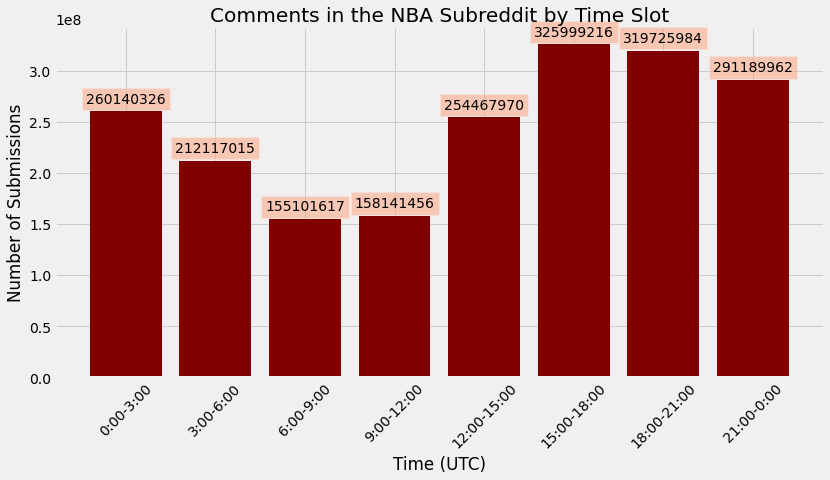

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
com_nba_summary_sorted = com_nba_summary.sort_values('time_order')

def addlabels_nba(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+8000000,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))

fig = plt.figure(figsize = (27, 6))
# creating the bar plot
plt.subplot(1, 2, 1)
plt.bar('time_slot', 'count', data=com_nba_summary_sorted, color='maroon') 
addlabels_nba(com_nba_summary_sorted['time_slot'], com_nba_summary_sorted['count'])
plt.xlabel("Time (UTC)")
plt.xticks(rotation = 45)
plt.ylabel("Number of Submissions")
plt.title("Comments in the NBA Subreddit by Time Slot")

## Save the plot in the plot dir so that it can be checked into the repo
plot_fpath = os.path.join(PLOT_DIR, 'comments_in_the_NBA_subreddit_by_time_slot.png')
plt.savefig(plot_fpath)
plt.show()

The majority of comments appear to be posted from 15:00 - 24:00 UTC. There is a noticable dip from the 0:00 - 3:00 slot to the 3:00 - 6:00 slot, <br>
and an even further dip where the number of comments remain at similar levels from 6:00 - 12:00.

Now that we know the distribution of times in which comments are posted, we can conduct further analysis on the average sentiment of the comments for each given <br>
time slot as an interesting starting point for our sentiment analysis. This will be continued at a later date!

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
#Selecting post game threads from the commanders subreddithttps://adb-265272803014794.14.azuredatabricks.net/?o=265272803014794#
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

#filtering out posts only from astros subreddit
yankees_pgt = submissions.filter( col("subreddit") == "NYYankees" )
#filtering posts to only be from the astros subreddit bot
yankees_pgt = yankees_pgt.filter(col('author') == 'Yankeebot')
#converting to utc
yankees_pgt = yankees_pgt.withColumn("created_utc", from_unixtime(col("created_utc")))
#selecting astros games from the 2021 season (between first and last game)
yankees_pgt = yankees_pgt.filter( (col("created_utc") > unix_timestamp(lit('2021-04-01 00:00:00')).cast('timestamp')) & \
                                   (col("created_utc") < unix_timestamp(lit('2021-10-05 00:00:00')).cast('timestamp')))
yankees_pgt = yankees_pgt.filter(col("title").rlike("Game Thread*."))

In [0]:
import os
CSV_DIR = os.path.join("data", "csv")
os.makedirs(CSV_DIR, exist_ok=True)
# save the results to csv
#fpath = os.path.join(CSV_DIR, "top_ten_posts.csv")
#top_ten_posts.to_csv(fpath)

In [0]:
yankees_gs = yankees_pgt.toPandas()

# save the results to csv
fpath = os.path.join(CSV_DIR, "yankees_gs .csv")
yankees_gs .to_csv(fpath)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field crosspost_parent_list. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('approved_at_utc', StringType(), True), StructField('approved_by', StringType(), True), StructField('archived', BooleanType(), True), StructField('author', StringType(), True), StructField('author_flair_css_class', StringType(), True), StructField('author_flair_text', StringType(), True), StructField('banned_at_utc', StringType(), True), StructField('banned_by', StringType(), True), StructField('brand_safe', BooleanType(), True), StructField('can_gild', BooleanType(), True), StructField('can_mod_post', BooleanType(),